## Make Allan Deviation Plot

In [1]:
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import allantools

from andbro__querrySeismoData import __querrySeismoData

## Configurations

In [2]:
## Configurations

config = {}

config['tbeg'] = obs.UTCDateTime("2023-01-19 10:00")
config['tend'] = obs.UTCDateTime("2023-01-19 18:00")

# config['seed'] = "BW.DROMY..FJZ"
config['seed'] = "BW.ROMY.10.BJZ"

config['repository'] = "george"

# config['outpath'] = f''
# config['outfile'] = f''
# config['outfigs'] = f''

config['net'], config['sta'], config['loc'], config['cha'] = config['seed'].split(".")

## ALLAN
config['errorbars'] = False
config['relative'] = True

config['tau'] = 'octave', ## all, octave, decade
config['method'] = 'oadev' ## adev, oadev, mdev

## Load Data

In [3]:
st, inv = __querrySeismoData(    
                            seed_id=config['seed'],
                            starttime=config['tbeg']-10,
                            endtime=config['tend']+10,
                            repository=config['repository'],
                            path=None,
                            restitute=False,
                            detail=None,
                            fill_value=None,
)

/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1.2, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


In [4]:
st.detrend("demean")

st.remove_sensitivity(inv)

st.trim(config['tbeg'], config['tend'])

1 Trace(s) in Stream:
BW.ROMY.10.BJZ | 2023-01-19T09:59:59.990199Z - 2023-01-19T17:59:59.990199Z | 20.0 Hz, 576001 samples

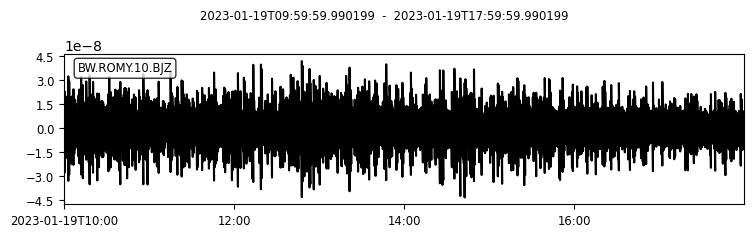

In [5]:
st.plot();

## Compute Allan Dev

In [6]:
## define tau range e.g. 5 (= 10⁵) and number of samples N
upper = 6
lower = -4
N = 200

## list of tau values in seconds
taux = np.logspace(lower, upper, N)

## smallest sampling in seconds
dtaux = taux[1]-taux[0]

## sampling rate
df = st[0].stats.sampling_rate

In [7]:
## normal allan deviation
## allan = (taus1, adevs1, errors, ns) 


if config['method'] == "oadev":
    allan = allantools.oadev(st[0].data, 
                             data_type='freq', 
                             rate=df, 
                             taus=config['tau'],
                             )    

elif config['method'] == "mdev":
    allan = allantools.mdev(st[0].data, 
                            data_type='freq', 
                            rate=df, 
                            taus=config['tau'],
                            )    
    
elif config['method'] == "adev":
    allan = allantools.adev(st[0].data, 
                            data_type='freq', 
                            rate=df, 
                            taus=config['tau'],
                            )

TypeError: '<' not supported between instances of 'numpy.ndarray' and 'float'

## Plotting

In [ ]:
def __makeplot_allan_deviation(config, st, allan):

    taus, adev, errors, ns = allan[0], allan[1], allan[2], allan[3]

    day = st[0].stats.starttime.date
    tt1 = str(st[0].stats.starttime.time)[:8]
    tt2 = str(st[0].stats.endtime.time)[:8]  
    
    if config['relative']:
        adev = adev / 7.3e-5
        
    ## -------------------------------------------
    fig, ax = plt.subplots(1,1, figsize=(12,8))

    font = 14


    if config['errorbars']:
        ax.scatter(taus, adev, color='darkred', label=f"{config['sta']}.{config['cha']}", zorder=2)
        ax.errorbar(taus, adev, yerr=allan[2], color='darkred', fmt='none', zorder=1)
    else:
        ax.plot(taus, adev, color='darkred', label=f"{config['sta']}.{config['cha']}")
        

    ax.set_title(f"Allan Deviation for {config['net']}.{config['cha']} on {day}  [{tt1}-{tt2} UTC]", fontsize=font+3)
    ax.set_xlabel(r"$\tau$ [s]", fontsize=font)
    
    if config['relative']:
        ax.set_ylabel(r"Allan Deviation  $\Omega$/$\Omega_E$", fontsize=font)
    else:
        ax.set_ylabel(r"Allan Deviation $\sigma_{\tau}$ [rad/s]", fontsize=font)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.legend(fontsize=font-2)

    ax.grid(True, which="both", ls="--")

    ax.tick_params(labelsize=font-1)

    plt.show();
    
__makeplot_allan_deviation(config, st, allan)

In [ ]:
def __makeplot_allan_deviation2(config, st, allan):

    taus, adev, errors, ns = allan[0], allan[1], allan[2], allan[3]

    day = st[0].stats.starttime.date
    tt1 = str(st[0].stats.starttime.time)[:8]
    tt2 = str(st[0].stats.endtime.time)[:8]  
    
    if config['relative']:
        adev = adev / 7.3e-5
        
    ## -------------------------------------------
    fig = plt.figure(constrained_layout=False, figsize=(15,8))
    
    widths = [1]
    heights = [1/5,4/5]
    spec = fig.add_gridspec(ncols=1, nrows=2, width_ratios=widths, height_ratios=heights)
    print(spec)
    plt.subplots_adjust(hspace=0.15, wspace=0.02)

    ax1 = fig.add_subplot(spec[0])
    ax2 = fig.add_subplot(spec[1])
    
    font = 14

    # --------------------
    ax1.plot(st[0].times()/3600, st[0].data*1e9, 'k')

    ax1.set_title(f"Allan Deviation for {config['sta']} on {day}  [{tt1}-{tt2} UTC]", fontsize=font+3)
    ax1.set_xlabel(f"Time (hours)", fontsize=font, labelpad=-2)
    ax1.set_ylabel(f"$\omega$ (nrad/s)", fontsize=font)
    
    # --------------------
    if config['errorbars']:
        ax2.scatter(taus, adev, color='darkred', label=f"{config['sta']}.{config['cha']}", zorder=2)
        ax2.errorbar(taus, adev, yerr=allan[2], color='darkred', fmt='none', zorder=1)
    else:
        ax2.plot(taus, adev, color='darkred', label=f"{config['sta']}.{config['cha']}")
        

    ax2.set_xlabel(r"$\tau$ [s]", fontsize=font)
    
    if config['relative']:
        ax2.set_ylabel(r"Allan Deviation  $\Omega$/$\Omega_E$", fontsize=font)
    else:
        ax2.set_ylabel(r"Allan Deviation $\sigma_{\tau}$ [rad/s]", fontsize=font)

    ax2.set_xscale('log')
    ax2.set_yscale('log')

    ax2.legend(fontsize=font-2)

    ax2.grid(True, which="both", ls="--")

    ax2.tick_params(labelsize=font-1)

    plt.show();
    
__makeplot_allan_deviation2(config, st, allan)